CONCLUSÕES:
- 8 Features explicam o mesmo que 28 Features. Features correlacionadas tem baixo poder preditivo, uma já é suficiente.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle as p
import itertools
import seaborn.apionly as sns
import seaborn
import xgboost as xgb
from sklearn.cross_validation import train_test_split

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


##### LOAD FEATURES

Carrega o train set com a features e deleta possíveis nulos

In [2]:
train_features = pd.read_csv('./quora_train_engineered.csv')

In [3]:
print(len(train_features))
train_features.head(1)

404290


,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,12,...,5.081614,1.0,94.023324,0.371408,0.168999,0.186557,0.031817,-0.091902,0.050416,0.337301


In [4]:
train_features.columns

Index(['question1', 'question2', 'is_duplicate', 'len_q1', 'len_q2',
       'diff_len', 'len_char_q1', 'len_char_q2', 'len_word_q1', 'len_word_q2',
       'common_words', 'fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio',
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'wmd', 'norm_wmd',
       'cosine_distance', 'cityblock_distance', 'jaccard_distance',
       'canberra_distance', 'euclidean_distance', 'minkowski_distance',
       'braycurtis_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
       'kur_q2vec'],
      dtype='object')

In [5]:
train_features = train_features.dropna()
print(len(train_features))

402489


In [6]:
train_features = train_features.replace([np.inf, -np.inf], np.nan).dropna()
print(len(train_features))

393325


In [7]:
train_features.describe()

,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
count,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000,...,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000,393325.000000
mean,0.373147,60.311986,60.915289,-0.603303,20.358383,20.346022,11.087015,11.333958,4.577741,58.347913,...,9.168629,0.931813,131.565848,0.662708,0.298953,0.367942,0.010352,0.010401,-0.052685,-0.054127
std,0.483641,29.816552,33.826257,32.729612,4.103479,4.232956,5.403554,6.298609,3.106880,21.973585,...,4.264971,0.252065,47.306981,0.308122,0.139067,0.195305,0.135298,0.134904,0.265730,0.264215
min,0.000000,1.000000,2.000000,-1080.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.669451,-0.669451,-0.857844,-0.829341
25%,0.000000,40.000000,40.000000,-12.000000,18.000000,17.000000,8.000000,7.000000,2.000000,41.000000,...,6.601517,1.000000,112.802617,0.477007,0.215150,0.245304,-0.080458,-0.080101,-0.238232,-0.239380
50%,0.000000,52.000000,51.000000,0.000000,20.000000,20.000000,10.000000,10.000000,4.000000,59.000000,...,9.194268,1.000000,138.476616,0.664615,0.299724,0.351586,0.011966,0.011953,-0.081463,-0.082807
75%,1.000000,72.000000,72.000000,12.000000,23.000000,23.000000,13.000000,13.000000,6.000000,76.000000,...,11.827348,1.000000,160.990508,0.854588,0.385468,0.471933,0.101535,0.100640,0.101924,0.100228
max,1.000000,623.000000,1169.000000,487.000000,52.000000,55.000000,125.000000,237.000000,41.000000,100.000000,...,20.511668,1.000000,230.190867,1.496936,0.682163,1.101037,0.675833,0.781670,2.288984,2.227666


##### Normalize

In [8]:
from sklearn.preprocessing import StandardScaler

def normalize(train_data):
    train_data = train_data.values
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(train_data[0::,3::])

    y_train = train_data[0::, 2]

    return X_train, y_train

In [89]:
x_train, y_train = normalize(train_features)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


[0 0 0 ..., 0 0 0]


In [15]:
print(X_train)
print(set(y_train))
print(np.shape(X_train))
print(np.shape(y_train))

[[ 0.19076723 -0.11574718  0.29341364 ..., -0.75833929  0.38799228
   1.48147671]
 [-0.31230969  0.80070182 -1.11204323 ...,  0.62491078  1.26705555
   0.07449748]
 [ 0.42553645 -0.05662144  0.4461807  ...,  0.99443795  0.29896417
  -1.58963206]
 ..., 
 [-1.45261735 -1.29826201  0.01843295 ..., -1.16928459 -0.85365441
  -1.30004414]
 [ 1.12984413  1.95365378 -0.98982959 ..., -1.22979346 -1.24111792
  -0.41197355]
 [-0.78184814 -0.47050163 -0.22599433 ...,  1.31754859  2.03282159
   2.04993959]]
{0, 1}
(393325, 28)
(393325,)


##### Import Metrics

In [10]:
from sklearn import model_selection

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(clf, X, y_true, classes=['Non Duplicated', 'Duplicated']):
    y_pred = clf.predict(X)
    y_pred = np.asarray(y_pred, dtype=np.int)
    y_true = np.asarray(y_true, dtype=np.int)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return roc_auc_score(y_true, y_pred)

##### Primeira tentativa

Cross Validation e XGBoost 

Sem tuning dos parametros

In [19]:
X_traincv, X_testcv, y_traincv, y_testcv = model_selection.train_test_split(X_train,
                                                                            y_train,
                                                                            test_size=0.3,
                                                                            random_state=0)
print(len(X_traincv), len(X_testcv), len(y_traincv), len(y_testcv))
y_traincv = np.asarray(y_traincv, dtype="|S6")

275327 117998 275327 117998


In [23]:
import xgboost

clf_xgb1 = xgboost.sklearn.XGBClassifier(base_score=0.5,
                                        learning_rate=0.1,
                                        n_estimators=250,
                                        max_delta_step=0,
                                        max_depth=3,
                                        min_child_weight=1,
                                        missing=None,
                                        gamma=0,
                                        subsample=1,
                                        colsample_bylevel=1,
                                        colsample_bytree=1,
                                        objective= 'binary:logitraw',
                                        #objective='multi:softprob',
                                        reg_alpha=0, 
                                        reg_lambda=1,
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=0,
                                        silent=False,).fit(X_traincv, y_traincv)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


NameError: name 'clf_xgb' is not defined

In [24]:
a = clf_xgb1.predict_proba(X_testcv)
print('LogLoss Score: {}'.format(log_loss(list(y_testcv), a)))

LogLoss Score: 3.941093784479713


Classification Report
               precision    recall  f1-score   support

Não Repetidas       0.70      0.93      0.80     74095
    Repetidas       0.72      0.32      0.44     43903

  avg / total       0.71      0.70      0.66    117998

ROC Score: 0.6224522738989107
Accuracy Score: 0.7002830556450109
Average Precision Score: 0.6459209678723716
f1 Score: 0.44140131412686373
LogLoss Score: 10.351893359158984
Confusion matrix, without normalization
[[68659  5436]
 [29930 13973]]


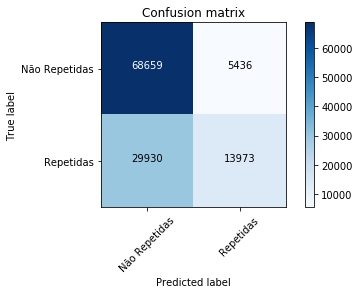

In [28]:
roc_xgb = clf_eval(clf_xgb1, X_testcv, y_testcv)

#### Seleção de Features

O LogLoss teve um resultado de 3.94, o que não é muito bom. Isso pode ter acontecido pelo excesso de features correlacionadas.
Por exemplo, temos várias medidas de fuzzy, distância e skew. Para minimizar esses problemas, vamos analizar a correlação entre as features e selecionar a melhor combinação.

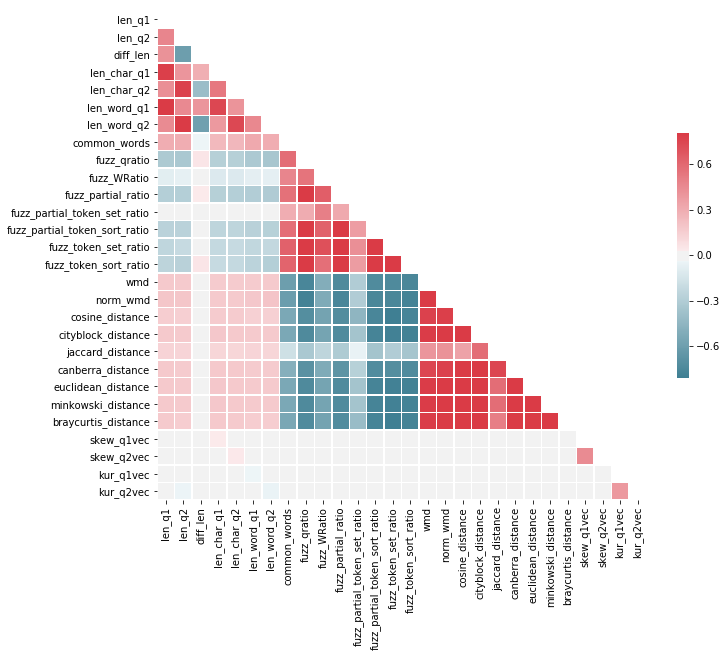

In [37]:
corr = train_features.iloc[:, 3:].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Na matriz de correlação, procuramos as métricas menos correlacionadas, i.e. as em cinza. As escolhas mais óbvias são:

- diff_len
- commom_words
- fuzzy_partial_token_set_ratio / fuzzy_partial_token_sort_ratio
- jaccard_distance
- skews
- kurs

In [28]:
X_train, y_train = normalize(train_features[['question1', 'question2', 'is_duplicate',
                          'diff_len','common_words', 'fuzz_partial_token_set_ratio',
                         'jaccard_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
                           'kur_q2vec']])
np.shape(X_train)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


(393325, 8)

In [29]:
X_traincv, X_testcv, y_traincv, y_testcv = model_selection.train_test_split(X_train,
                                                                            y_train,
                                                                            test_size=0.3,
                                                                            random_state=0)
print(len(X_traincv), len(X_testcv), len(y_traincv), len(y_testcv))
y_traincv = np.asarray(y_traincv, dtype="|S6")

275327 117998 275327 117998


In [30]:
import xgboost

clf_xgb2 = xgboost.sklearn.XGBClassifier(base_score=0.5,
                                        learning_rate=0.1,
                                        n_estimators=250,
                                        max_delta_step=0,
                                        max_depth=3,
                                        min_child_weight=1,
                                        missing=None,
                                        gamma=0,
                                        subsample=1,
                                        colsample_bylevel=1,
                                        colsample_bytree=1,
                                        objective= 'binary:logitraw',
                                        #objective='multi:softprob',
                                        reg_alpha=0, 
                                        reg_lambda=1,
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=0,
                                        silent=False,).fit(X_traincv, y_traincv)

LogLoss Score: 6.0288627082241035
Classification Report
               precision    recall  f1-score   support

Não Repetidas       0.64      0.97      0.78     74095
    Repetidas       0.69      0.09      0.16     43903

  avg / total       0.66      0.65      0.55    117998

ROC Score: 0.5337893425423015
Accuracy Score: 0.6466550280513229
Average Precision Score: 0.5582756623319481
f1 Score: 0.16330871729009475
Confusion matrix, without normalization
[[72235  1860]
 [39834  4069]]


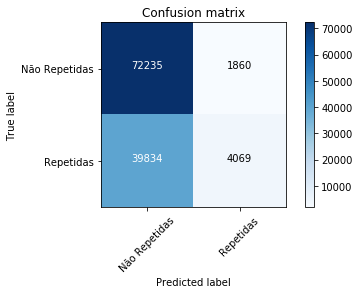

In [31]:
a = clf_xgb2.predict_proba(X_testcv)
print('LogLoss Score: {}'.format(log_loss(list(y_testcv), a)))
roc_xgb = clf_eval(clf_xgb2, X_testcv, y_testcv)

Aparentemente não foi um sucesso. O logloss aumentou o que indica que algo deve ser mudado. 

Analisando os notebooks do Kaggle, encontro um XGBoost que consegue 0.35 só com TF-IDF e sem normalizar. Ele balanceia as amostras positivas dele porque o test set tem menos respostas positivas que negativas. Também implementa o xgboost de uma maneira diferente. 

Tentaremos implementar as diferenças.

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

In [44]:
x_train, y_train = normalize(train_features)
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [46]:
def equalize(x_train, y_train):

    pos_train = x_train[y_train == 1]
    neg_train = x_train[y_train == 0]

    # Now we oversample the negative class
    # There is likely a much more elegant way to do this...
    p = 0.165
    scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
    while scale > 1:
        neg_train = pd.concat([neg_train, neg_train])
        scale -=1
    neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
    print(len(pos_train) / (len(pos_train) + len(neg_train)))

    x_train = pd.concat([pos_train, neg_train])
    y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
    del pos_train, neg_train
    return x_train, y_train
x_train, y_train = equalize(x_train, y_train)

0.19526634562875442


In [40]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [41]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.685192	valid-logloss:0.685205
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.620639	valid-logloss:0.62077
[20]	train-logloss:0.576143	valid-logloss:0.576366
[30]	train-logloss:0.544892	valid-logloss:0.545191
[40]	train-logloss:0.522711	valid-logloss:0.523073
[50]	train-logloss:0.506883	valid-logloss:0.507297
[60]	train-logloss:0.495566	valid-logloss:0.496022
[70]	train-logloss:0.487477	valid-logloss:0.48797
[80]	train-logloss:0.481705	valid-logloss:0.482227
[90]	train-logloss:0.477589	valid-logloss:0.478133
[100]	train-logloss:0.474671	valid-logloss:0.475233
[110]	train-logloss:0.472612	valid-logloss:0.473189
[120]	train-logloss:0.471164	valid-logloss:0.471753
[130]	train-logloss:0.470149	valid-logloss:0.470749
[140]	train-logloss:0.469442	valid-logloss:0.47005
[150]	train-logloss:0.46895	valid-logloss:0.469565
[160]	train-logloss:0.468608	val

Parece que temos uma melhora!

LogLoss foi pra 0.46, se continuarmos nesse ritmo, extrapolando linearmente teremos logloss=-5.08. 

Agora sério, esse teste foi com todas as features. Vamos tentar usar as features não correlacionadas para ver se temos melhora.

In [52]:
x_train, y_train = normalize(train_features[['question1', 'question2', 'is_duplicate',
                          'diff_len','common_words', 'fuzz_partial_token_set_ratio',
                         'jaccard_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
                           'kur_q2vec']])
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

x_train, y_train = equalize(x_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


0.19526634562875442


In [53]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [55]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.685176	valid-logloss:0.685188
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.62047	valid-logloss:0.620588
[20]	train-logloss:0.575831	valid-logloss:0.576039
[30]	train-logloss:0.54444	valid-logloss:0.544727
[40]	train-logloss:0.522108	valid-logloss:0.522464
[50]	train-logloss:0.506128	valid-logloss:0.506545
[60]	train-logloss:0.494648	valid-logloss:0.495118
[70]	train-logloss:0.4864	valid-logloss:0.486916
[80]	train-logloss:0.480463	valid-logloss:0.481018
[90]	train-logloss:0.47621	valid-logloss:0.476801
[100]	train-logloss:0.47315	valid-logloss:0.473771
[110]	train-logloss:0.470945	valid-logloss:0.471591
[120]	train-logloss:0.469369	valid-logloss:0.470036
[130]	train-logloss:0.468232	valid-logloss:0.468917
[140]	train-logloss:0.467428	valid-logloss:0.468128
[150]	train-logloss:0.46684	valid-logloss:0.467555
[160]	train-logloss:0.466396	valid-

In [61]:
d_test = xgb.DMatrix(x_valid)
a = bst.predict(d_test)
print('LogLoss Score: {}'.format(log_loss(list(y_valid), a)))

LogLoss Score: 0.46605083155858595


Classification Report
                precision    recall  f1-score   support

Non Duplicated       0.80      1.00      0.89    324023
    Duplicated       0.00      0.00      0.00     78837

   avg / total       0.65      0.80      0.72    402860



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ROC Score: 0.5
Accuracy Score: 0.8043067070446309
Average Precision Score: 0.5978466464776846


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 Score: 0.0
Confusion matrix, without normalization
[[324023      0]
 [ 78837      0]]


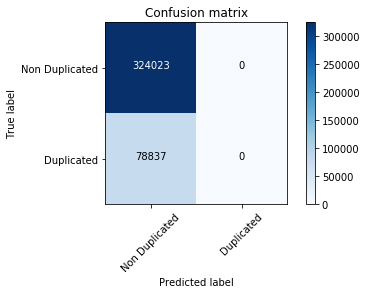

In [74]:
roc_xgb = clf_eval(bst, d_test, y_valid)

In [72]:
a = pd.Series(bst.predict(d_test))
len(a[a > 0.5])

0

Houston, we got a problem!

Realmente essa matriz confusão não era o que esperavamos. O modelo simplesmente não diz que nenhuma das questões é duplicada. Isso e fazer um modelo que só retorna 0 é a mesma coisa. 

O problema pode ser:
- A equalização de proporção de respostas certas e erradas
- A normalização das features
- O instanciamento do modelo
- As features

Em suma, qualquer coisa. Vamos começar do primeiro tópico

In [92]:
x_train, y_train = normalize(train_features[['question1', 'question2', 'is_duplicate',
                          'diff_len','common_words', 'fuzz_partial_token_set_ratio',
                         'jaccard_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
                           'kur_q2vec']])

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [93]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [94]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.689135	valid-logloss:0.68911
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.656359	valid-logloss:0.656069
[20]	train-logloss:0.633043	valid-logloss:0.63259
[30]	train-logloss:0.615777	valid-logloss:0.615213
[40]	train-logloss:0.602835	valid-logloss:0.602224
[50]	train-logloss:0.592906	valid-logloss:0.592265
[60]	train-logloss:0.585349	valid-logloss:0.584643
[70]	train-logloss:0.579387	valid-logloss:0.578658
[80]	train-logloss:0.574628	valid-logloss:0.573904
[90]	train-logloss:0.57094	valid-logloss:0.570228
[100]	train-logloss:0.56802	valid-logloss:0.567344
[110]	train-logloss:0.565637	valid-logloss:0.564995
[120]	train-logloss:0.563727	valid-logloss:0.563117
[130]	train-logloss:0.562118	valid-logloss:0.561539
[140]	train-logloss:0.56081	valid-logloss:0.560252
[150]	train-logloss:0.55965	valid-logloss:0.559114
[160]	train-logloss:0.558721	valid

Classification Report
                precision    recall  f1-score   support

Non Duplicated       0.63      1.00      0.77     49371
    Duplicated       0.00      0.00      0.00     29294

   avg / total       0.39      0.63      0.48     78665

ROC Score: 0.5
Accuracy Score: 0.6276107544651369
Average Precision Score: 0.6861946227674315


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7fd7ceeea470>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/xgboost/core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


f1 Score: 0.0
Confusion matrix, without normalization
[[49371     0]
 [29294     0]]


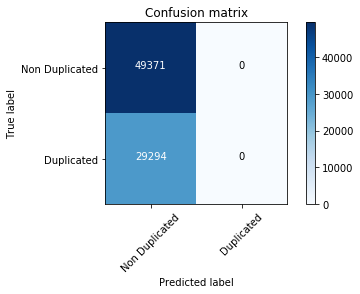

In [96]:
d_test = xgb.DMatrix(x_valid)
a = bst.predict(d_test)
roc_xgb = clf_eval(bst, d_test, y_valid)

Bom, parece que o problema é grave mesmo. Vamos recorrer à literatura.

Alguns artigos interessantes:
    http://xgboost.readthedocs.io/en/latest/model.html
    
    http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html
    
    http://xgboost.readthedocs.io/en/latest/parameter.html
    
    https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/
    
    https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set#!n=18

Parece que o modelo está muito genérico. Isso pode ser devido ao baixo eta(learning_rate). Vou aumentar em uma ordem de grandeza para ver o resultado.

In [14]:
x_train, y_train = normalize(train_features[['question1', 'question2', 'is_duplicate',
                          'diff_len','common_words', 'fuzz_partial_token_set_ratio',
                         'jaccard_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
                           'kur_q2vec']])

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.2
params['max_depth'] = 6

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


[0]	train-logloss:0.654147	valid-logloss:0.654054
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.559623	valid-logloss:0.55976
[20]	train-logloss:0.550196	valid-logloss:0.55111
[30]	train-logloss:0.546462	valid-logloss:0.548236
[40]	train-logloss:0.543681	valid-logloss:0.546396
[50]	train-logloss:0.540769	valid-logloss:0.54467
[60]	train-logloss:0.538394	valid-logloss:0.543245
[70]	train-logloss:0.536159	valid-logloss:0.541928
[80]	train-logloss:0.534359	valid-logloss:0.540962
[90]	train-logloss:0.531995	valid-logloss:0.539738
[100]	train-logloss:0.529336	valid-logloss:0.538454
[110]	train-logloss:0.527518	valid-logloss:0.537461
[120]	train-logloss:0.525975	valid-logloss:0.536676
[130]	train-logloss:0.524203	valid-logloss:0.535845
[140]	train-logloss:0.522887	valid-logloss:0.535194
[150]	train-logloss:0.520491	valid-logloss:0.534076
[160]	train-logloss:0.518446	va

Classification Report
                precision    recall  f1-score   support

Non Duplicated       0.63      1.00      0.77     49371
    Duplicated       0.00      0.00      0.00     29294

   avg / total       0.39      0.63      0.48     78665

ROC Score: 0.5
Accuracy Score: 0.6276107544651369
Average Precision Score: 0.6861946227674315


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 Score: 0.0
Confusion matrix, without normalization
[[49371     0]
 [29294     0]]


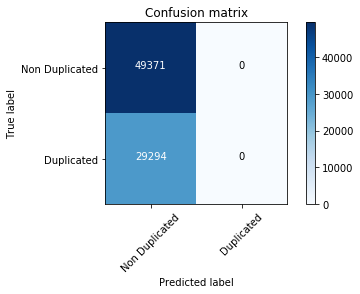

In [19]:
d_test = xgb.DMatrix(x_valid)
a = bst.predict(d_test)
roc_xgb = clf_eval(bst, d_test, y_valid)

### LOGIT

In [30]:
x_train, y_train = normalize(train_features[['question1', 'question2', 'is_duplicate',
                          'diff_len','common_words', 'fuzz_partial_token_set_ratio',
                         'jaccard_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
                           'kur_q2vec']])

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [32]:
y_train = np.asarray(y_train, dtype="|S6")

In [33]:
from sklearn.linear_model import LogisticRegression as LR

LR_tf = LR(penalty='l2',
               dual=False,
               tol=0.0001,
               C=1.0,
               fit_intercept=True,
               intercept_scaling=1,
               class_weight=None,
               random_state=0,
               solver='liblinear',
               max_iter=100,
               multi_class='ovr',
               verbose=0).fit(x_train, y_train)

Classification Report
                precision    recall  f1-score   support

Non Duplicated       0.65      0.90      0.75     49371
    Duplicated       0.51      0.17      0.26     29294

   avg / total       0.60      0.63      0.57     78665

ROC Score: 0.5375698071180387
Accuracy Score: 0.6303184389499777
Average Precision Score: 0.4961784454820396
f1 Score: 0.25974290441644393
Confusion matrix, without normalization
[[44482  4889]
 [24192  5102]]


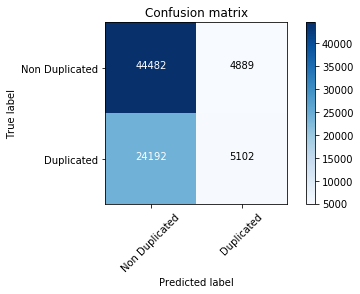

In [36]:
roc_xgb = clf_eval(LR_tf,  x_valid, y_valid)

In [37]:
y_valid = np.asarray(y_valid, dtype="|S6")
print('LogLoss Score: {}'.format(log_loss(list(y_valid), LR_tf.predict_proba(x_valid))))

LogLoss Score: 0.6187880180578937


### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
randomforest_tf = RandomForestClassifier(n_estimators=300, max_features='auto', bootstrap=False, 
                               oob_score=False, n_jobs=-1, random_state=0).fit(x_train, y_train)

Classification Report
                precision    recall  f1-score   support

Non Duplicated       0.75      0.79      0.77     49371
    Duplicated       0.62      0.56      0.59     29294

   avg / total       0.70      0.71      0.70     78665

ROC Score: 0.6755445071333
Accuracy Score: 0.7055361342401322
Average Precision Score: 0.6689990383099601
f1 Score: 0.58530559633356
Confusion matrix, without normalization
[[39154 10217]
 [12947 16347]]


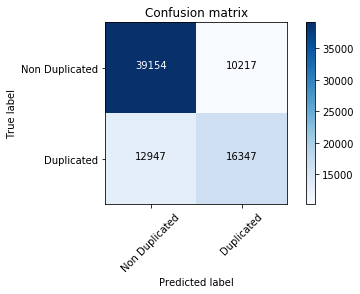

In [39]:
roc_xgb = clf_eval(randomforest_tf,  x_valid, y_valid)

In [40]:
y_valid = np.asarray(y_valid, dtype="|S6")
print('LogLoss Score: {}'.format(log_loss(list(y_valid), randomforest_tf.predict_proba(x_valid))))

LogLoss Score: 0.5397633868275682


### VOTING

In [47]:
from sklearn.ensemble import VotingClassifier

vot_tf_idf = VotingClassifier(estimators=[('rf', randomforest_tf),
                                             ('lr', LR_tf)], voting='soft').fit(x_train, y_train)


NameError: name 'bst' is not defined

Classification Report
                precision    recall  f1-score   support

Non Duplicated       0.71      0.89      0.79     49371
    Duplicated       0.67      0.38      0.48     29294

   avg / total       0.69      0.70      0.67     78665

ROC Score: 0.6331855337538188
Accuracy Score: 0.6987859912286277
Average Precision Score: 0.6393813018684388
f1 Score: 0.48188397874620076
Confusion matrix, without normalization
[[43951  5420]
 [18275 11019]]


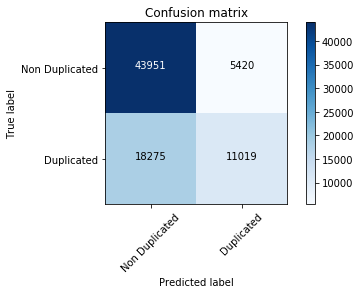

In [45]:
roc_xgb = clf_eval(vot_tf_idf,  x_valid, y_valid)

In [46]:
y_valid = np.asarray(y_valid, dtype="|S6")
print('LogLoss Score: {}'.format(log_loss(list(y_valid), vot_tf_idf.predict_proba(x_valid))))

LogLoss Score: 0.5502968692024861
